## Probe trajectories expected in histology
This image shows, for each mouse that has probe insertions and trajectories in DataJoint, the location, probe name, angle and session date for each penetration.

__Note a few things__
* the view is seen from the top, i.e. same as coordinate system during stereotactic  insertion
* 0, 0 is Bregma
* only those penetrations that are in DJ are plotted. if any are missing, please do the following:
    1. check that all sessions for that mouse have probe trajectories, with *both* 'Planned' and 'Micro-manipulator' provenance, logged in Alyx
    2. wait 24 hours for these entries to propagate to DJ. if they don't appear in DJ, ask Shan.
    3. re-run the notebook (or ask me nicely to do it for you) if you have added trajectories/penetrations
* these are *not* the brains that have gone through histology, just the ones that are listed in Alyx. Check with Steve's histology dashboard to see if all of your brains have been imaged.

Anne Urai, CSHL, 2020

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import os

import datajoint as dj
from ibl_pipeline import subject
ephys = dj.create_virtual_module('ephys', 'ibl_ephys')
figpath = os.path.join(os.path.expanduser('~'), 'Data/Figures_IBL')

Connecting anneurai@datajoint.internationalbrainlab.org:3306


In [2]:
# lab_name = "churchlandlab"
traj = ephys.ProbeInsertion * (ephys.ProbeTrajectory & 'insertion_data_source = "Micro-manipulator"') \
        * subject.Subject * subject.SubjectLab
traj = traj.proj('subject_nickname', 'x', 'y', 'theta', 'phi', 'theta', 'depth', 'lab_name',
                 'probe_label', session_date='DATE(session_start_time)')
traj = traj.fetch(format='frame').reset_index()
traj['probe_phi'] = traj['phi'].map({180:'180deg', 0:'0deg'})
traj['angle'] = traj.theta

traj['theta_name'] = traj['theta'].map({10:'10deg', 15:'15deg', 17:'17deg'})
traj['probe_name'] = traj.probe_label + ', ' + traj.theta_name
# traj['subject_nickname'] = traj.lab_name + ', ' + traj.subject_nickname
traj = traj.sort_values(by=['subject_nickname'])
traj['source'] = 'datajoint'
traj_dj = traj.copy()

In [3]:
# sns.set(style="darkgrid", context="paper")
# markers = ['o', 's', 'v', 'P', '*', 'h', '^', 'H', 'D', 'd', 'P', 'X','p',  '^', '<', '>']

# g, axes = plt.subplots(traj.subject_nickname.nunique(), 1, figsize=(5,4*traj.subject_nickname.nunique()))
# for probe, ax in zip(traj.subject_nickname.unique(), axes.flatten()):
    
#     # skip strange mice
#     sns.lineplot(data=traj[traj.subject_nickname==probe], 
#                 x='x', y='y', hue="session_date", style="probe_name",
#                 markers=True, linewidth=0, markersize=8, mfc='none', mec='auto',
#                 palette='Set1', ax=ax, legend='full', dashes=False)

#     ax.set_title(probe, fontsize=12)
#     ax.set(xlim=[-4500, 4500], ylim=[-7750, 4250], xlabel='', ylabel='')
#     ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
#     ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
#     ax.grid(b=True, which='minor')
#     ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# plt.tight_layout()
# #g.savefig(os.path.join(figpath, 'probe_trajectories_forhistology.pdf'))

## same plot but with ONE

In [4]:
## REPEAT WITH ONE
from oneibl.one import ONE
one = ONE()
trajs = one.alyx.rest('trajectories', 'list', provenance='micro-manipulator')
traj = pd.DataFrame(list(trajs))

Connected to https://alyx.internationalbrainlab.org as anneu


In [5]:
# get the subject info out of the 'session' column
for kix, k in enumerate(traj.session[0].keys()):
    tmp_var = []
    for id, c in traj.iterrows():
        if k in c['session'].keys():
            tmp = c['session'][k]
        else:
            tmp = np.nan
        tmp_var.append(tmp)
        # also add the date
    traj[k] = tmp_var
    
traj['theta_name'] = traj['theta'].map({10:'10deg', 15:'15deg', 17:'17deg'})
traj['probe_name'] = traj.probe_name + ', ' + traj.theta_name
traj['session_date'] = traj['start_time'].str[0:10]
traj = traj.sort_values(by=['subject'])
traj['source'] = 'one'
traj['subject_nickname'] = traj['subject']
traj_alyx = traj.copy()
print(traj.columns)

Index(['id', 'probe_insertion', 'x', 'y', 'z', 'depth', 'theta', 'phi', 'roll',
       'provenance', 'session', 'probe_name', 'coordinate_system', 'json',
       'subject', 'start_time', 'number', 'lab', 'task_protocol', 'theta_name',
       'session_date', 'source', 'subject_nickname'],
      dtype='object')


In [6]:
## merge the two
traj = pd.concat([traj_dj, traj_alyx], sort=False)

# loop over subjects and sources
traj['sp'] = traj.subject_nickname + ', ' + traj.source
traj = traj.sort_values(by=['sp'])

## plot datajoint and ONE results side by side

done


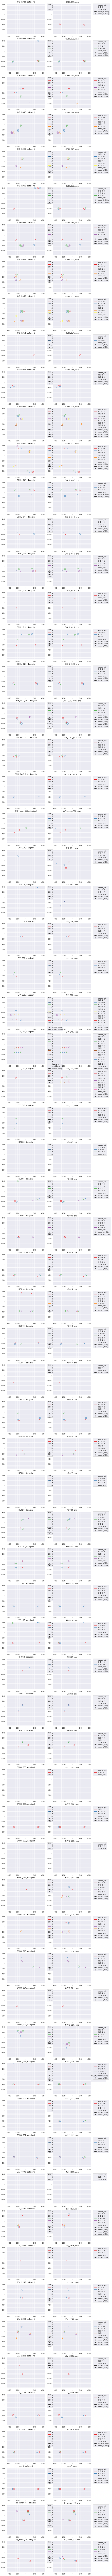

In [7]:
sns.set(style="darkgrid", context="paper")
markers = ['o', 's', 'v', 'P', '*', 'h', '^', 'H', 'D', 'd', 'X','p']
g, axes = plt.subplots(traj.subject_nickname.nunique(), 2, figsize=(9,4*traj.subject.nunique()))

for sp, ax in zip(traj.sp.unique(), axes.flatten()):
    
    df = traj[traj.sp==sp]
    sns.lineplot(data=df, x='x', y='y', hue="session_date", style="probe_name", 
                 hue_order=sorted(df.session_date.unique()), 
                 style_order=sorted(df.probe_name.dropna().unique()), 
                 markers=True, linewidth=0, markersize=8, mfc='none', mec='auto',palette='Set1', 
                 ax=ax, legend='full', dashes=False)

    ax.set_title(sp, fontsize=12)
    ax.set(xlim=[-4500, 4500], ylim=[-7750, 4250], xlabel='', ylabel='')
    ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.grid(b=True, which='minor')
    ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# plt.tight_layout()
#g.savefig(os.path.join(figpath, 'probe_trajectories_forhistology.pdf'))
print('done')